# import stuff

In [7]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import glob
import netCDF4
import pandas
#import wrf
import string
import seaborn
import matplotlib.colors
import cmocean
import cftime
import scipy.ndimage

import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

# open control data (cesm 30 day runs)

In [8]:
cont_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/ens_mean_cesm_files/'
cont_filename = 'B_1850_CAM5.30days.cam0400.clm0400.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
cont_cam_ds = xarray.open_dataset(cont_fileroot+cont_filename, decode_times=False)

In [9]:
rainc_400 = cont_cam_ds['PRECC'].sel(lat=slice(-30,30),lon=slice(270,330)).values
rainnc_400 = cont_cam_ds['PRECL'].sel(lat=slice(-30,30),lon=slice(270,330)).values
qvapor_400 = cont_cam_ds['Q'].sel(lat=slice(-30,30),lon=slice(270,330)).values
pblh_400 = cont_cam_ds['PBLH'].sel(lat=slice(-30,30),lon=slice(270,330)).values
geopot_400 = cont_cam_ds['Z3'].sel(lat=slice(-30,30),lon=slice(270,330)).values
cldfra_400 = cont_cam_ds['CLOUD'].sel(lat=slice(-30,30),lon=slice(270,330)).values
tk_400 = cont_cam_ds['T'].sel(lat=slice(-30,30),lon=slice(270,330)).values

In [10]:
time = cont_cam_ds['time'].values
lat = cont_cam_ds['lat'].sel(lat=slice(-30,30)).values
lon = cont_cam_ds['lon'].sel(lon=slice(270,330)).values
landmask = cont_cam_ds['LANDFRAC'].isel(time=0).sel(lat=slice(-30,30),lon=slice(270,330)).values

In [11]:
xlong,xlat = numpy.meshgrid(lon,lat)

# open phys data

In [12]:
phys_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm1000.ens_10members/ens_mean_cesm_files/'
phys_filename = 'B_1850_CAM5.30days.cam0400.clm1000.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
phys_cam_ds = xarray.open_dataset(phys_fileroot+phys_filename, decode_times=False)

In [13]:
rainc_1000 = phys_cam_ds['PRECC'].sel(lat=slice(-30,30),lon=slice(270,330)).values
rainnc_1000 = phys_cam_ds['PRECL'].sel(lat=slice(-30,30),lon=slice(270,330)).values
qvapor_1000 = phys_cam_ds['Q'].sel(lat=slice(-30,30),lon=slice(270,330)).values
pblh_1000 = phys_cam_ds['PBLH'].sel(lat=slice(-30,30),lon=slice(270,330)).values
#geopot_1000 = phys_cam_ds['Z3']
cldfra_1000 = phys_cam_ds['CLOUD'].sel(lat=slice(-30,30),lon=slice(270,330)).values
tk_1000 = phys_cam_ds['T'].sel(lat=slice(-30,30),lon=slice(270,330)).values

# get time data

In [14]:
time_cesm = cont_cam_ds['time']
time_converted = netCDF4.num2date(time_cesm.values, time_cesm.units, time_cesm.calendar)

time_manual = []
for t_idx in range(time_converted.size):
    year=time_converted[t_idx].year
    month=time_converted[t_idx].month
    day=time_converted[t_idx].day
    hour=time_converted[t_idx].hour
    minute=time_converted[t_idx].minute
    hour_round = round(hour+minute/60)
    time_manual.append(cftime.DatetimeNoLeap(year,month,day,hour_round))
    
time_datetimes = numpy.array(time_manual)

In [15]:
g = 9.81

# get latlon subset

In [16]:
lat_hi = 10
lat_lo = -10
latlon_indices = (xlat<=lat_hi)&(xlat>=lat_lo)&(landmask>.5)

# PBLH diffs

In [17]:
pblh_diffs = pblh_1000-pblh_400

In [18]:
pblh_diffs_latlon_nan = numpy.copy(pblh_diffs)
pblh_diffs_latlon_nan[:,~latlon_indices]=numpy.nan

# qvapor

In [19]:
qvapor_diffs = qvapor_1000-qvapor_400

In [20]:
qvapor_diffs_latlon_nan = numpy.copy(qvapor_diffs)
qvapor_diffs_latlon_nan[:,:,~latlon_indices]=numpy.nan

In [21]:
qvapor_diffs_latmean = numpy.nanmean(qvapor_diffs_latlon_nan, axis=2)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


# cldfra

In [22]:
cldfra_diffs = cldfra_1000-cldfra_400

In [23]:
cldfra_diffs_latlon_nan = numpy.copy(cldfra_diffs)
cldfra_diffs_latlon_nan[:,:,~latlon_indices]=numpy.nan

In [24]:
cldfra_diffs_latmean = numpy.nanmean(cldfra_diffs_latlon_nan, axis=2)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


# tk

In [25]:
tk_diffs = tk_1000 - tk_400

In [26]:
tk_diffs_latlon_nan = numpy.copy(tk_diffs)
tk_diffs_latlon_nan[:,:,~latlon_indices]=numpy.nan

In [27]:
tk_diffs_latmean = numpy.nanmean(tk_diffs_latlon_nan, axis=2)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


# geopotential

In [28]:
geopot_400_latlon_nan = numpy.copy(geopot_400)
geopot_400_latlon_nan[:,:,~latlon_indices]=numpy.nan

In [29]:
geopot_400_latmean = numpy.nanmean(geopot_400_latlon_nan, axis=2)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


# pblh

In [30]:
pblh_diffs_latlon_nan = numpy.copy(pblh_diffs)
pblh_diffs_latlon_nan[:,~latlon_indices]=numpy.nan

In [31]:
pblh_400_latlon_nan = numpy.copy(pblh_400)
pblh_400_latlon_nan[:,~latlon_indices]=numpy.nan

In [32]:
pblh_1000_latlon_nan = numpy.copy(pblh_1000)
pblh_1000_latlon_nan[:,~latlon_indices]=numpy.nan

Set lontidues west of 290º equal to NaN so that Andes don't have a weird boundary layer

In [33]:
lon_lo = 290-360
lon_hi = 320-360
lon_indices = (xlong[0,:]<lon_lo)|(xlong[0,:]>lon_hi)

In [34]:
pblh_diffs_latmean = numpy.nanmean(pblh_diffs_latlon_nan, axis=1)
pblh_400_latmean = numpy.nanmean(pblh_400_latlon_nan, axis=1)
pblh_1000_latmean = numpy.nanmean(pblh_1000_latlon_nan, axis=1)

pblh_400_latmean[:,~lon_indices] = numpy.nan
pblh_1000_latmean[:,~lon_indices] = numpy.nan

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


plot qvapor and wind climatologies

In [35]:
# make color map
minval=0. # for inferno:  0.18
maxval=0.95 # for inferno: 1.0
n=256
full_cmap = mp.get_cmap('YlGnBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list(\
    'trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval),\
    full_cmap(numpy.linspace(minval, maxval, n)))

# cmap creation

In [37]:
colors1 = cmocean.cm.turbid_r(numpy.linspace(0., 1, 128))
colors2 = cmocean.cm.deep(numpy.linspace(0, 1, 128))

# combine them and build a new colormap
colors = numpy.vstack((colors1, colors2))
cmap_precip = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

## plot qvapor, cldfra, and tk differences at 15:00

In [38]:
time_datetimes_shifted = time_datetimes + datetime.timedelta(hours=-4)

In [39]:
first_day = time_datetimes[0].day

In [40]:
time_indices_1500 = [(t.hour in [15]) and (t.day in range(first_day+1,first_day+10)) for t in time_datetimes_shifted]
time_indices_1400 = [(t.hour in [14]) and (t.day in range(first_day+1,first_day+10)) for t in time_datetimes_shifted]

In [41]:
qvapor_diffs_latmean_timechunk = numpy.nanmean(qvapor_diffs_latmean[time_indices_1500,:,:], axis=0)
cldfra_diffs_latmean_timechunk = numpy.nanmean(cldfra_diffs_latmean[time_indices_1500,:,:], axis=0)
tk_diffs_latmean_timechunk = numpy.nanmean(tk_diffs_latmean[time_indices_1500,:,:], axis=0)
#ua_diffs_latmean_timechunk = numpy.nanmean(ua_diffs_latmean[time_indices_1500,:,:], axis=0)
#wa_diffs_latmean_timechunk = numpy.nanmean(wa_diffs_latmean[time_indices_1500,:,:], axis=0)


pblh_400_latmean_timechunk = numpy.nanmean(pblh_400_latmean[time_indices_1400,:], axis=0)
pblh_1000_latmean_timechunk = numpy.nanmean(pblh_1000_latmean[time_indices_1400,:], axis=0)

geopot_400_latmean_timechunk = numpy.nanmean(geopot_400_latmean[time_indices_1500,:,:], axis=0)
#ptot_400_latmean_timechunk = numpy.nanmean(ptot_400_latmean[time_indices_1500,:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


# create grid

In [42]:
xx,zz=numpy.meshgrid(xlong[0,:],geopot_400_latmean_timechunk[:,:].mean(axis=1)/(1000*g))

In [43]:
import astropy.convolution
kernel = astropy.convolution.Gaussian2DKernel(x_stddev=1.5)

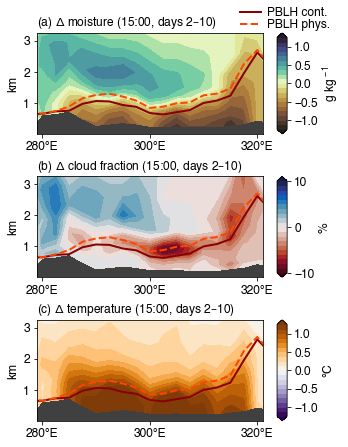

In [47]:
fontsize = 12

fig = mp.figure(figsize=(4,6))

#axes[0].contourf(qvapor_diffs_latmean_timechunk)
#axes[1].contourf(cldfra_diffs_latmean_timechunk)
#axes[2].contourf(tk_diffs_latmean_timechunk)

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []
contour_list = []



ax = fig.add_subplot(311)#, projection=cartopy.crs.PlateCarree())
levels = numpy.arange(-1.25,1.251,0.125)

contour_plot = ax.contourf(xx,\
                           geopot_400_latmean_timechunk/(1000.),\
                           qvapor_diffs_latmean_timechunk*1000.,\
                           levels=levels,\
                           cmap=cmap_precip,\
                           extend='both')
ax.plot(xx[0,:],pblh_400_latmean_timechunk/1000.,c='darkred', label='PBLH cont.', zorder=3, lw=2)
ax.plot(xx[0,:],pblh_1000_latmean_timechunk/1000.,c='orangered',ls='--', label='PBLH phys.', zorder=3, lw=2)
ax.tick_params(labelsize=fontsize)
ax.set_xlim(279,321)
ax.set_ylim(0,3.25)
ax.set_yticks([1,2,3])
ax.set_xticks([280,300,320])
ax.set_xticklabels(xticks_format)
ax.set_ylabel('km', fontsize=fontsize)
ax.set_facecolor('0.25')
ax_list.append(ax)
contour_list.append(contour_plot)




ax = fig.add_subplot(312)#, projection=cartopy.crs.PlateCarree())
levels = numpy.arange(-10,10.1,1)
contour_plot = ax.contourf(xx,\
                           geopot_400_latmean_timechunk/(1000.),\
                           cldfra_diffs_latmean_timechunk*100.,\
                           levels=levels,\
                           cmap=cmocean.cm.balance_r,\
                           extend='both')
ax.plot(xx[0,:],pblh_400_latmean_timechunk/1000.,c='darkred', label='PBLH cont.', zorder=3, lw=2)
ax.plot(xx[0,:],pblh_1000_latmean_timechunk/1000.,c='orangered',ls='--', label='PBLH phys.', zorder=3, lw=2)
ax.tick_params(labelsize=fontsize)
ax.set_ylim(0,3.25)
ax.set_xlim(279,321)
ax.set_yticks([1,2,3])
ax.set_xticks([280,300,320])
ax.set_xticklabels(xticks_format)
ax.set_ylabel('km', fontsize=fontsize)
ax.set_facecolor('0.25')
ax_list.append(ax)
contour_list.append(contour_plot)








every_nth_lon=10
every_nth_z=1
z_indices=[1,3,5,6,7,8,9,10,11,12,13,14,15,16]
quiver_scale = .3 # 0.05 for 850-600, 0.1 for below 850
quiver_shaft_width = .2#.75
quiver_key_scale = 1
quiver_color = '0.1'
quiver_head_width = quiver_shaft_width*15
quiver_head_length = quiver_shaft_width*15

ax = fig.add_subplot(313)#, projection=cartopy.crs.PlateCarree())
levels = numpy.arange(-1.25,1.251,0.125)
contour_plot = ax.contourf(xx,\
                           geopot_400_latmean_timechunk/(1000.),\
                           tk_diffs_latmean_timechunk,\
                           levels=levels,\
                           cmap='PuOr_r',\
                           extend='both')
ax.plot(xx[0,:],pblh_400_latmean_timechunk/1000.,c='darkred', label='PBLH cont.', zorder=3, lw=2)
ax.plot(xx[0,:],pblh_1000_latmean_timechunk/1000.,c='orangered',ls='--', label='PBLH phys.', zorder=3, lw=2)
ax.tick_params(labelsize=fontsize)
ax.set_ylim(0,3.25)
ax.set_xlim(279,321)
ax.set_yticks([1,2,3])
ax.set_xticks([280,300,320])
ax.set_xticklabels(xticks_format)
ax.set_ylabel('km', fontsize=fontsize)
ax.set_facecolor('0.25')
ax_list.append(ax)
contour_list.append(contour_plot)


# quiver_plot = ax.quiver(xx[z_indices,::every_nth_lon]+360.,\
#           geopot_400_latmean_timechunk[z_indices,::every_nth_lon]/(g*1000.),\
#           ua_diffs_latmean_timechunk[z_indices,::every_nth_lon],\
#           wa_diffs_latmean_timechunk[z_indices,::every_nth_lon]*100.,\
#           units='xy', scale=quiver_scale, \
#           color=quiver_color, zorder=3, \
#           width=quiver_shaft_width)#, headwidth=quiver_head_width,\
#           #headlength=quiver_head_length)

fig.tight_layout(h_pad=2)



handles, labels = ax_list[0].get_legend_handles_labels()
legend = ax_list[0].legend(handles, labels, fontsize=fontsize, ncol=1, bbox_to_anchor=(0.9,1.02), \
                   edgecolor='None', facecolor='None', fancybox=False, bbox_transform=ax_list[0].transAxes, \
                   loc='lower left', labelspacing=0, \
                   borderaxespad=0, borderpad=0, handlelength=1.75, \
                   handletextpad=0.5)

ax_list[0].text(s='(a) $\Delta$ moisture (15:00, days 2–10)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax_list[0].transAxes)
ax_list[1].text(s='(b) $\Delta$ cloud fraction (15:00, days 2–10)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax_list[1].transAxes)
ax_list[2].text(s='(c) $\Delta$ temperature (15:00, days 2–10)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax_list[2].transAxes)

axpos1 = ax_list[0].get_position()
axpos2 = ax_list[1].get_position()
axpos3 = ax_list[2].get_position()

cbar_ax1 = fig.add_axes([axpos1.x1+0.05,axpos1.y0,0.035,axpos1.height])
cbar_ax2 = fig.add_axes([axpos2.x1+0.05,axpos2.y0,0.035,axpos2.height])
cbar_ax3 = fig.add_axes([axpos3.x1+0.05,axpos3.y0,0.035,axpos3.height])

cbar1 = fig.colorbar(contour_list[0], cax=cbar_ax1)
cbar_ax1.tick_params(labelsize=fontsize)
cbar1.set_ticks([-1,-.5,0,.5,1])
cbar1.set_label('g kg$^{\,-1}$', fontsize=fontsize)

cbar2 = fig.colorbar(contour_list[1], cax=cbar_ax2)
cbar_ax2.tick_params(labelsize=fontsize)
cbar2.set_ticks([-20,-10,0,10,20])
cbar2.set_label('%', fontsize=fontsize)

cbar3 = fig.colorbar(contour_list[2], cax=cbar_ax3)
cbar_ax3.tick_params(labelsize=fontsize)
cbar3.set_ticks([-1.5,-1,-.5,0,.5,1,1.5])
cbar3.set_label('$\degree$C', fontsize=fontsize)


# quiver_key = ax_list[2].quiverkey(quiver_plot, \
#                                   coordinates='axes', \
#                                   X=1, Y=1.1, labelpos='E', \
#                                   label='', \
#                                   U=quiver_key_scale)
# quiver_key_text = ax_list[2].text(s=str(quiver_key_scale)+' m s$^{\,-1}$',\
#                                   x=1.01, y=1.02,\
#                                   ha='left', va='bottom',\
#                                   transform=ax_list[2].transAxes, \
#                                   fontsize=fontsize)


fig.savefig('../figures/SI_fig05.pdf', dpi=600, bbox_inches='tight')



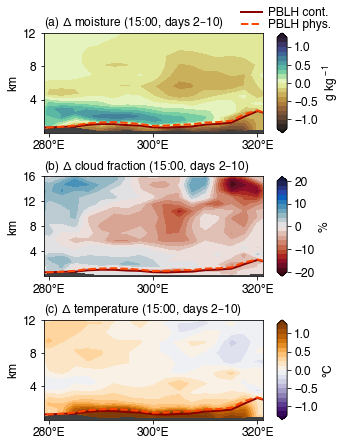

In [48]:
fontsize = 12

fig = mp.figure(figsize=(4,6))

#axes[0].contourf(qvapor_diffs_latmean_timechunk)
#axes[1].contourf(cldfra_diffs_latmean_timechunk)
#axes[2].contourf(tk_diffs_latmean_timechunk)

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []
contour_list = []



ax = fig.add_subplot(311)#, projection=cartopy.crs.PlateCarree())
levels = numpy.arange(-1.25,1.251,0.125)
contour_plot = ax.contourf(xx,\
                           geopot_400_latmean_timechunk/(1000.),\
                           qvapor_diffs_latmean_timechunk*1000.,\
                           levels=levels,\
                           cmap=cmap_precip,\
                           extend='both')
ax.plot(xx[0,:],pblh_400_latmean_timechunk/1000.,c='darkred', label='PBLH cont.', zorder=3, lw=2)
ax.plot(xx[0,:],pblh_1000_latmean_timechunk/1000.,c='orangered',ls='--', label='PBLH phys.', zorder=3, lw=2)
ax.tick_params(labelsize=fontsize)
ax.set_xlim(279,321)
ax.set_ylim(0,12)
ax.set_yticks([4,8,12])
ax.set_xticks([280,300,320])
ax.set_xticklabels(xticks_format)
ax.set_ylabel('km', fontsize=fontsize)
ax.set_facecolor('0.25')
ax_list.append(ax)
contour_list.append(contour_plot)




ax = fig.add_subplot(312)#, projection=cartopy.crs.PlateCarree())
levels = numpy.arange(-20,20.1,2)
contour_plot = ax.contourf(xx,\
                           geopot_400_latmean_timechunk/(1000.),\
                           cldfra_diffs_latmean_timechunk*100.,\
                           levels=levels,\
                           cmap=cmocean.cm.balance_r,\
                           extend='both')
ax.plot(xx[0,:],pblh_400_latmean_timechunk/1000.,c='darkred', label='PBLH cont.', zorder=3, lw=2)
ax.plot(xx[0,:],pblh_1000_latmean_timechunk/1000.,c='orangered',ls='--', label='PBLH phys.', zorder=3, lw=2)
ax.tick_params(labelsize=fontsize)
ax.set_ylim(0,16)
ax.set_xlim(279,321)
ax.set_yticks([4,8,12,16])
ax.set_xticks([280,300,320])
ax.set_xticklabels(xticks_format)
ax.set_ylabel('km', fontsize=fontsize)
ax.set_facecolor('0.25')
ax_list.append(ax)
contour_list.append(contour_plot)



every_nth_lon=10
every_nth_z=1
z_indices=[1,3,5,6,7,8,9,10,11,12,13,14,15,16]
quiver_scale = .3 # 0.05 for 850-600, 0.1 for below 850
quiver_shaft_width = .2#.75
quiver_key_scale = 1
quiver_color = '0.1'
quiver_head_width = quiver_shaft_width*15
quiver_head_length = quiver_shaft_width*15

ax = fig.add_subplot(313)#, projection=cartopy.crs.PlateCarree())
levels = numpy.arange(-1.25,1.251,0.125)
contour_plot = ax.contourf(xx,\
                           geopot_400_latmean_timechunk/(1000.),\
                           tk_diffs_latmean_timechunk,\
                           levels=levels,\
                           cmap='PuOr_r',\
                           extend='both')
ax.plot(xx[0,:],pblh_400_latmean_timechunk/1000.,c='darkred', label='PBLH cont.', zorder=3, lw=2)
ax.plot(xx[0,:],pblh_1000_latmean_timechunk/1000.,c='orangered',ls='--', label='PBLH phys.', zorder=3, lw=2)
ax.tick_params(labelsize=fontsize)
ax.set_ylim(0,12)
ax.set_xlim(279,321)
ax.set_yticks([4,8,12])
ax.set_xticks([280,300,320])
ax.set_xticklabels(xticks_format)
ax.set_ylabel('km', fontsize=fontsize)
ax.set_facecolor('0.25')
ax_list.append(ax)
contour_list.append(contour_plot)


# quiver_plot = ax.quiver(xx[z_indices,::every_nth_lon]+360.,\
#           geopot_400_latmean_timechunk[z_indices,::every_nth_lon]/(g*1000.),\
#           ua_diffs_latmean_timechunk[z_indices,::every_nth_lon],\
#           wa_diffs_latmean_timechunk[z_indices,::every_nth_lon]*100.,\
#           units='xy', scale=quiver_scale, \
#           color=quiver_color, zorder=3, \
#           width=quiver_shaft_width)#, headwidth=quiver_head_width,\
#           #headlength=quiver_head_length)

fig.tight_layout(h_pad=2)



handles, labels = ax_list[0].get_legend_handles_labels()
legend = ax_list[0].legend(handles, labels, fontsize=fontsize, ncol=1, bbox_to_anchor=(0.9,1.02), \
                   edgecolor='None', facecolor='None', fancybox=False, bbox_transform=ax_list[0].transAxes, \
                   loc='lower left', labelspacing=0, \
                   borderaxespad=0, borderpad=0, handlelength=1.75, \
                   handletextpad=0.5)

ax_list[0].text(s='(a) $\Delta$ moisture (15:00, days 2–10)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax_list[0].transAxes)
ax_list[1].text(s='(b) $\Delta$ cloud fraction (15:00, days 2–10)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax_list[1].transAxes)
ax_list[2].text(s='(c) $\Delta$ temperature (15:00, days 2–10)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax_list[2].transAxes)

axpos1 = ax_list[0].get_position()
axpos2 = ax_list[1].get_position()
axpos3 = ax_list[2].get_position()

cbar_ax1 = fig.add_axes([axpos1.x1+0.05,axpos1.y0,0.035,axpos1.height])
cbar_ax2 = fig.add_axes([axpos2.x1+0.05,axpos2.y0,0.035,axpos2.height])
cbar_ax3 = fig.add_axes([axpos3.x1+0.05,axpos3.y0,0.035,axpos3.height])

cbar1 = fig.colorbar(contour_list[0], cax=cbar_ax1)
cbar_ax1.tick_params(labelsize=fontsize)
cbar1.set_ticks([-1,-.5,0,.5,1])
cbar1.set_label('g kg$^{\,-1}$', fontsize=fontsize)

cbar2 = fig.colorbar(contour_list[1], cax=cbar_ax2)
cbar_ax2.tick_params(labelsize=fontsize)
cbar2.set_ticks([-20,-10,0,10,20])
cbar2.set_label('%', fontsize=fontsize)

cbar3 = fig.colorbar(contour_list[2], cax=cbar_ax3)
cbar_ax3.tick_params(labelsize=fontsize)
cbar3.set_ticks([-1.5,-1,-.5,0,.5,1,1.5])
cbar3.set_label('$\degree$C', fontsize=fontsize)


# quiver_key = ax_list[2].quiverkey(quiver_plot, \
#                                   coordinates='axes', \
#                                   X=1, Y=1.1, labelpos='E', \
#                                   label='', \
#                                   U=quiver_key_scale)
# quiver_key_text = ax_list[2].text(s=str(quiver_key_scale)+' m s$^{\,-1}$',\
#                                   x=1.01, y=1.02,\
#                                   ha='left', va='bottom',\
#                                   transform=ax_list[2].transAxes, \
#                                   fontsize=fontsize)


fig.savefig('../figures/REVISION_moisture_clouds_temp_1500_pblh_1400_days2-10_zcoords_CESM_full_atmos.pdf', dpi=600, bbox_inches='tight')

